In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import time
from random import randint

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

In [73]:
def score(y_true,y_pred):
    score = 100*(10-np.sqrt(np.sum((y_pred/y_true-1)**2)/(y_true.shape[0])/6))
    return score

def mae(y_true,y_pred):
    score = np.mean(np.abs((y_pred-y_true)/y_true))
    return score

# Initialize Data

In [74]:
# Training_Data
aux_train     = pd.read_csv('Data/TrainingData/AuxillaryTable.csv')
aux_train     = aux_train.drop('planet_ID', axis=1)
spec_train    = np.load('Data/TrainingData/spec_matrix.npy')
wave_train    = spec_train[:,:,0]
noise_train   = spec_train[:,:,2]
wavebin_train = spec_train[:,:,3]
spec_train    = spec_train[:,:,1]

targets_train = pd.read_csv('Data/TrainingData/GroundTruth/FM_Parameter_Table.csv')
targets_train = targets_train.drop('planet_ID', axis=1)
quart_train   = pd.read_csv('Data/TrainingData/GroundTruth/QuartilesTable.csv')
quart_train   = quart_train.drop('planet_ID', axis=1)
dist_train    = h5py.File('Data/TrainingData/GroundTruth/Tracedata.hdf5','r')

# Test Data
aux_test      = pd.read_csv('Data/TestData/AuxillaryTableTest.csv')
aux_test      = aux_test.drop('planet_ID', axis=1)
aux_test      = aux_test.drop('Unnamed: 0', axis=1)
spec_test     = np.load('Data/TestData/test_spec.npy')
noise_test    = np.load('Data/TestData/test_noise.npy')

# Process Data

In [75]:
# Training Data
aux_train_means     = np.mean(aux_train,axis=0)
aux_train_stds      = np.std(aux_train,axis=0)
aux_train           = (aux_train - aux_train_means)/aux_train_stds

spec_train_means    = np.mean(spec_train,axis=1)
spec_train_stds     = np.std(spec_train,axis=1)
spec_train          = np.transpose(np.transpose(spec_train - spec_train_means[:,None])/spec_train_stds)
#spec_train          = (spec_train - spec_train_means)/spec_train_stds

noise_train_means   = np.mean(noise_train,axis=1)
noise_train_stds    = np.std(noise_train,axis=1)
noise_train         = np.transpose(np.transpose(noise_train - noise_train_means[:,None])/noise_train_stds)

targets_train_means = np.array([ np.mean(targets_train[targets_train.keys()[:]][:],axis=0) ])
targets_train_stds  = np.array([ np.std(targets_train[targets_train.keys()[:]][:],axis=0) ])
targets_train       = (targets_train - targets_train_means)/targets_train_stds

In [76]:
# limit out of 91k
N =  21988

x_train =  spec_train[:N]
#np.hstack([ aux_train.to_numpy()[:N,:],
y_train = targets_train.to_numpy()[:N,:]

x_train, x_test, y_train, y_test = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.25,
                                                    random_state=0)

# Support Vector Machine (SVM) Regression

In [77]:
scores_SVR = np.empty((6,1))
pred_SVR   = np.empty((y_test.shape[0],6))
for i in range(len(targets_train.keys()[:])):
    regr = SVR()
    regr.fit(x_train,y_train[:,i])
    pred_SVR = np.delete(pred_SVR,i,axis=1)
    pred_SVR = np.insert(pred_SVR,i,regr.predict(x_test),axis=1)
    scores_SVR[i] = regr.score(x_test,y_test[:,i])
    print('Accuracy for '+targets_train.keys()[i]+': ',np.round(scores_SVR[i],6))

Accuracy for planet_temp:  [0.952143]
Accuracy for log_H2O:  [0.905941]
Accuracy for log_CO2:  [0.978886]
Accuracy for log_CH4:  [0.963217]
Accuracy for log_CO:  [0.849456]
Accuracy for log_NH3:  [0.837907]


Scoring

In [78]:
y_pred_back_SVR = pred_SVR*targets_train_stds + targets_train_means
y_test_back_SVR = y_test*targets_train_stds + targets_train_means

score_SVR_ariel = score(y_test_back_SVR,y_pred_back_SVR)
score_SVR_mae   = mae(y_test_back_SVR,y_pred_back_SVR)
print('MAE: ',score_SVR_mae)
print('Ariel Score: ',score_SVR_ariel)

MAE:  0.041817285013943654
Ariel Score:  993.6257323242753


# k-Nearest Neighbors

In [79]:
#KNeighborsRegressor?

In [80]:
k = 5
neigh = KNeighborsRegressor(n_neighbors=k)
neigh.fit(x_train,y_train)
pred_KNN = neigh.predict(x_test)
score_KNN = neigh.score(x_test,y_test)
print('Accuracy: ',score_KNN)

Accuracy:  0.8340773943365756


Scoring

In [81]:
y_pred_back_KNN = pred_KNN*targets_train_stds + targets_train_means
y_test_back_KNN = y_test*targets_train_stds + targets_train_means

score_KNN_ariel = score(y_test_back_KNN,y_pred_back_KNN)
score_KNN_mae   = mae(y_test_back_KNN,y_pred_back_KNN)
print('MAE: ',score_KNN_mae)
print('Ariel Score: ',score_KNN_ariel)

MAE:  0.06748630205344947
Ariel Score:  990.1650898759792


# Decision Tree Regression 

In [85]:
#DecisionTreeRegressor?

In [86]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train,y_train)
pred_DTR  = dtr.predict(x_test)
score_DTR = dtr.score(x_test,y_test)
print('Accuracy: ', score_DTR)

Accuracy:  0.6818895821379846


Scoring

In [87]:
y_pred_back_DTR = pred_DTR*targets_train_stds + targets_train_means
y_test_back_DTR = y_test*targets_train_stds + targets_train_means

score_DTR_ariel = score(y_test_back_DTR,y_pred_back_DTR)
score_DTR_mae   = mae(y_test_back_DTR,y_pred_back_DTR)
print('MAE: ',score_DTR_mae)
print('Ariel Score: ',score_DTR_ariel)

MAE:  0.11027906518089636
Ariel Score:  983.6570804095643


# Random Forest Regression

In [88]:
rfr =  RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(x_train,y_train)
pred_RFR  = rfr.predict(x_test)
score_RFR = rfr.score(x_test,y_test)
print('Accuracy: ', score_RFR)

Accuracy:  0.8766074895471685


Scoring

In [89]:
y_pred_back_RFR = pred_RFR*targets_train_stds + targets_train_means
y_test_back_RFR = y_test*targets_train_stds + targets_train_means

score_RFR_ariel = score(y_test_back_RFR,y_pred_back_RFR)
score_RFR_mae   = mae(y_test_back_RFR,y_pred_back_RFR)
print('MAE: ',score_RFR_mae)
print('Ariel Score: ',score_RFR_ariel)

MAE:  0.06601962899468304
Ariel Score:  990.3293049029902


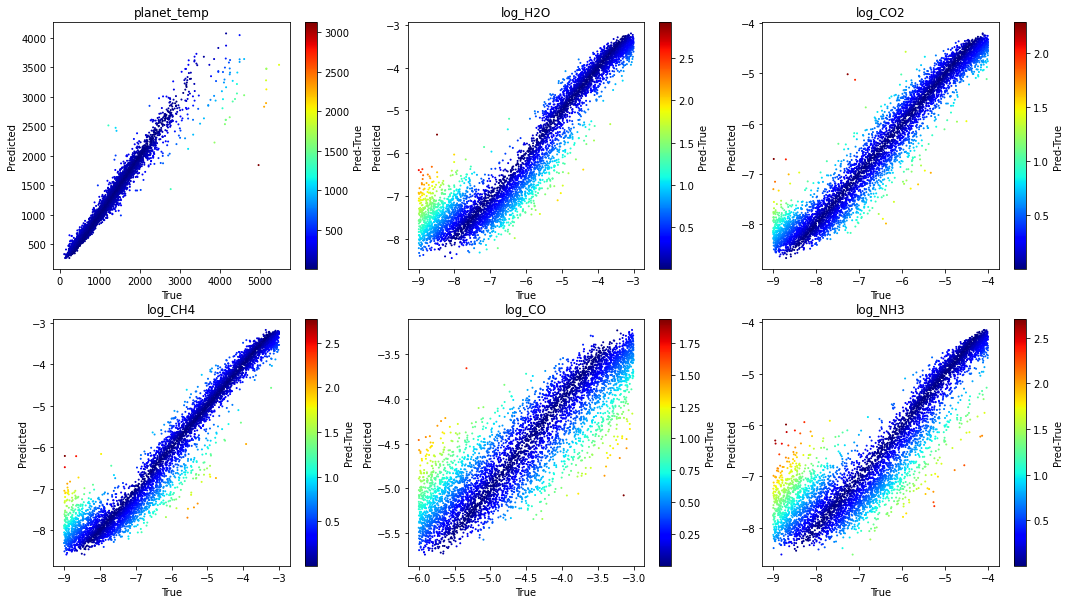

In [90]:
fig = plt.subplots(2,3,figsize=(18,10))

for i in range(len(targets_train.keys())):
    plt.subplot(231+i)
    plt.scatter(y_test_back_RFR[:,i],y_pred_back_RFR[:,i],c=np.abs(y_pred_back_RFR[:,i]-y_test_back_RFR[:,i]),cmap='jet',s=1)
    plt.colorbar(label='|Pred-True|')
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.title(targets_train.keys()[i])

# Ensemble Methods (Voting Regression)

## Train on FM, Check with FM Validation Data

In [92]:
SVR_reg = SVR()
KNN_reg = KNeighborsRegressor()
DTR_reg = DecisionTreeRegressor()
RFR_reg = RandomForestRegressor(n_estimators=100, random_state=42)

scores_vreg = np.empty((6,1))
pred_vreg   = np.empty((y_test.shape[0],6))
for i in range(len(targets_train.keys()[:])):
    estimators = [('svr', SVR_reg), ('knn', KNN_reg), ('dtr', DTR_reg), ('rfr', RFR_reg)]
    voting_reg = VotingRegressor(estimators=estimators)
    voting_reg.fit(x_train, y_train[:,i])
    pred_vreg = np.delete(pred_vreg,i,axis=1)
    pred_vreg = np.insert(pred_vreg,i,voting_reg.predict(x_test),axis=1)
    scores_vreg[i] = voting_reg.score(x_test,y_test[:,i])
    print('Accuracy for '+targets_train.keys()[i]+': ',np.round(scores_vreg[i],6))

Accuracy for planet_temp:  [0.960468]
Accuracy for log_H2O:  [0.917286]
Accuracy for log_CO2:  [0.976451]
Accuracy for log_CH4:  [0.967259]
Accuracy for log_CO:  [0.82611]
Accuracy for log_NH3:  [0.859009]


Scoring

In [93]:
y_pred_back_vreg = pred_vreg*targets_train_stds + targets_train_means
y_test_back_vreg = y_test*targets_train_stds + targets_train_means

score_vreg_ariel = score(y_test_back_vreg,y_pred_back_vreg)
score_vreg_mae   = mae(y_test_back_vreg,y_pred_back_vreg)
print('---Overall---')
print('MAE: ',score_vreg_mae)
print('Ariel Score: ',score_vreg_ariel)
print()

score_vreg_mae_each = np.empty((6,1))
score_vreg_ariel_each = np.empty((6,1))
for i in range(6):
    print('---'+targets_train.keys()[i]+'---')
    score_vreg_mae_each[i]    = mae(y_test_back_vreg[:,i],y_pred_back_vreg[:,i])
    score_vreg_ariel_each[i]  = score(y_test_back_vreg[:,i],y_pred_back_vreg[:,i])
    print('MAE: ',score_vreg_mae_each[i][0])
    print('Ariel Score: ',score_vreg_ariel_each[i][0])
    print()

---Overall---
MAE:  0.041567735887350264
Ariel Score:  993.5732557344354

---planet_temp---
MAE:  0.03465375489185368
Ariel Score:  997.4537352145237

---log_H2O---
MAE:  0.05017547447829484
Ariel Score:  997.1125548099396

---log_CO2---
MAE:  0.024539515570366172
Ariel Score:  998.6262321211876

---log_CH4---
MAE:  0.027616134245667178
Ariel Score:  998.1518571998951

---log_CO---
MAE:  0.06081590442175408
Ariel Score:  996.5843109242625

---log_NH3---
MAE:  0.05160563171616565
Ariel Score:  996.9157762864768



## Train on FM, Check with Quartile Central Value

In [94]:
yq         = quart_train[quart_train.keys()[:]][:21988]
yq         = yq.to_numpy()[:,:]
yq_means   = np.array([ np.mean(yq[:,:],axis=0) ])
yq_stds    = np.array([ np.std(yq[:,:],axis=0) ])

In [95]:
#y_test_quart_means = np.empty((1,6))
#for i in range(6):
#    y_test_quart_means = np.delete(y_test_quart_means,i,axis=1)
#    y_test_quart_means = np.insert(y_test_quart_means,i,np.mean(yq[:,i*3+3-2],axis=0),axis=1)
    
#y_test_quart_stds = np.empty((1,6))
#for i in range(6):
#    y_test_quart_stds = np.delete(y_test_quart_stds,i,axis=1)
#    y_test_quart_stds = np.insert(y_test_quart_stds,i,np.std(yq[:,i*3+3-2],axis=0),axis=1)

In [96]:
y_test_quart_central = np.empty((21988,6))
for i in range(6):
    y_test_quart_central = np.delete(y_test_quart_central,i,axis=1)
    y_test_quart_central = np.insert(y_test_quart_central,i,yq[:,i*3+3-2],axis=1)
    
#yq  = (yq - yq_means)/yq_stds
y_test_quart_central  = (y_test_quart_central - targets_train_means)/targets_train_stds

In [97]:
# Reinitialize train test split with quartiles central value as y_train now

N =  21988

x_train = spec_train[:N]

y_trainq = y_test_quart_central[:,:]

x_train, x_test, y_trainq, y_testq = train_test_split(x_train, 
                                                    y_trainq, 
                                                    test_size=0.25,
                                                    random_state=0)

In [98]:
scores_vreg_quart = np.empty((6,1))
pred_vreg_quart   = np.empty((y_test.shape[0],6))
for i in range(len(targets_train.keys()[:])):
    estimators = [('svr', SVR_reg), ('knn', KNN_reg), ('dtr', DTR_reg), ('rfr', RFR_reg)]
    voting_reg = VotingRegressor(estimators=estimators)
    voting_reg.fit(x_train, y_train[:,i])
    pred_vreg_quart = np.delete(pred_vreg_quart,i,axis=1)
    pred_vreg_quart = np.insert(pred_vreg_quart,i,voting_reg.predict(x_test),axis=1)
    scores_vreg_quart[i] = voting_reg.score(x_test,y_testq[:,i])
    print('Accuracy for '+targets_train.keys()[i]+': ',np.round(scores_vreg_quart[i],6))

Accuracy for planet_temp:  [0.959274]
Accuracy for log_H2O:  [0.780415]
Accuracy for log_CO2:  [0.890752]
Accuracy for log_CH4:  [0.855423]
Accuracy for log_CO:  [0.120121]
Accuracy for log_NH3:  [0.65814]


Scoring

In [99]:
y_pred_back_vreg_quart = pred_vreg_quart*targets_train_stds + targets_train_means
y_test_back_vreg_quart = y_testq*targets_train_stds + targets_train_means

score_vreg_quart_ariel = score(y_test_back_vreg_quart,y_pred_back_vreg_quart)
score_vreg_quart_mae   = mae(y_test_back_vreg_quart,y_pred_back_vreg_quart)
print('---Overall---')
print('MAE: ',score_vreg_quart_mae)
print('Ariel Score: ',score_vreg_quart_ariel)
print()

score_vreg_quart_mae_each = np.empty((6,1))
score_vreg_quart_ariel_each = np.empty((6,1))
for i in range(6):
    print('---'+targets_train.keys()[i]+'---')
    score_vreg_quart_mae_each[i]    = mae(y_test_back_vreg_quart[:,i],y_pred_back_vreg_quart[:,i])
    score_vreg_quart_ariel_each[i]  = score(y_test_back_vreg_quart[:,i],y_pred_back_vreg_quart[:,i])
    print('MAE: ',score_vreg_quart_mae_each[i][0])
    print('Ariel Score: ',score_vreg_quart_ariel_each[i][0])
    print()

---Overall---
MAE:  0.08312521933780179
Ariel Score:  987.4442637933371

---planet_temp---
MAE:  0.03468869258714737
Ariel Score:  997.4588574418437

---log_H2O---
MAE:  0.09181112628126875
Ariel Score:  995.0181568516351

---log_CO2---
MAE:  0.04602490432502647
Ariel Score:  997.2904330106117

---log_CH4---
MAE:  0.06585141776661543
Ariel Score:  996.119554021001

---log_CO---
MAE:  0.15972993015693307
Ariel Score:  991.2996138687103

---log_NH3---
MAE:  0.10064524490981952
Ariel Score:  994.6826687204887



# Aside on FM vs. Ariel Central and Voting Regressor FM vs. Ariel Central

## Pure FM vs. Ariel Central (in Mean Absolute Percent Error)

In [100]:
# Reinitialize previously standardized values

y_FM       = targets_train.to_numpy()[:21988,:]*targets_train_stds + targets_train_means
yq         = quart_train[quart_train.keys()[:]][:21988]
yq         = yq.to_numpy()[:,:]
y_test_quart = np.empty((21988,6))
for i in range(6):
    y_test_quart = np.delete(y_test_quart,i,axis=1)
    y_test_quart = np.insert(y_test_quart,i,yq[:,i*3+3-2],axis=1)

In [101]:
score_each_arielvsFM = np.empty((6,1))
for i in range(6):
    score_each_arielvsFM[i] = mae(y_FM[:,i],y_test_quart[:,i])

In [102]:
score_each_arielvsFM*100

array([[ 0.2204145 ],
       [ 8.76348366],
       [ 3.35733583],
       [ 6.55617516],
       [19.32932592],
       [10.50776433]])

## VotingR Predicted FM vs. Ariel Central (in Mean Absolute Percent Error)

In [103]:
y_test_back = y_test*targets_train_stds + targets_train_means
score_each_vtrvsFM = np.empty((6,1))
for i in range(6):
    score_each_vtrvsFM[i] = mae(y_test_back[:,i],y_pred_back_vreg[:,i])

In [104]:
score_each_vtrvsFM*100

array([[3.46537549],
       [5.01754745],
       [2.45395156],
       [2.76161342],
       [6.08159044],
       [5.16056317]])

## Train on Quartiles, Check with Quartiles Validation Data

In [105]:
yq         = quart_train[quart_train.keys()[:]][:21988]
yq         = yq.to_numpy()[:,:]
yq_means   = np.array([ np.mean(yq[:,:],axis=0) ])
yq_stds    = np.array([ np.std(yq[:,:],axis=0) ])

In [106]:
yq  = (yq - yq_means)/yq_stds

In [107]:
N =  21988
x_train = spec_train[:N]
y_train_quart_all = yq[:,:]

x_train, x_test, y_train_quart_all, y_test_quart_all = train_test_split(x_train, 
                                                                        y_train_quart_all, 
                                                                        test_size=0.25,
                                                                        random_state=0)

In [108]:
scores_vreg_quart_all = np.empty((18,1))
pred_vreg_quart_all   = np.empty((y_test_quart_all.shape[0],18))
for i in range(len(quart_train.keys()[:])):
    estimators = [('svr', SVR_reg), ('knn', KNN_reg), ('dtr', DTR_reg), ('rfr', RFR_reg)]
    voting_reg = VotingRegressor(estimators=estimators)
    voting_reg.fit(x_train, y_train_quart_all[:,i])
    pred_vreg_quart_all = np.delete(pred_vreg_quart_all,i,axis=1)
    pred_vreg_quart_all = np.insert(pred_vreg_quart_all,i,voting_reg.predict(x_test),axis=1)
    scores_vreg_quart_all[i] = voting_reg.score(x_test,y_test_quart_all[:,i])
    print('Accuracy for '+quart_train.keys()[i]+': ',np.round(scores_vreg_quart_all[i],6))

Accuracy for T_q1:  [0.961377]
Accuracy for T_q2:  [0.960904]
Accuracy for T_q3:  [0.962499]
Accuracy for log_H2O_q1:  [0.945315]
Accuracy for log_H2O_q2:  [0.950957]
Accuracy for log_H2O_q3:  [0.967897]
Accuracy for log_CO2_q1:  [0.963708]
Accuracy for log_CO2_q2:  [0.972988]
Accuracy for log_CO2_q3:  [0.979417]
Accuracy for log_CH4_q1:  [0.977561]
Accuracy for log_CH4_q2:  [0.984203]
Accuracy for log_CH4_q3:  [0.989818]
Accuracy for log_CO_q1:  [0.854444]
Accuracy for log_CO_q2:  [0.833545]
Accuracy for log_CO_q3:  [0.851285]
Accuracy for log_NH3_q1:  [0.924719]
Accuracy for log_NH3_q2:  [0.934909]
Accuracy for log_NH3_q3:  [0.952343]


In [109]:
y_pred_back_vreg_quart_all = pred_vreg_quart_all*yq_stds + yq_means
y_test_back_vreg_quart_all = y_test_quart_all*yq_stds + yq_means

score_vreg_quart_all_ariel = score(y_test_back_vreg_quart_all,y_pred_back_vreg_quart_all)
score_vreg_quart_all_mae   = mae(y_test_back_vreg_quart_all,y_pred_back_vreg_quart_all)
print('---Overall---')
print('MAE: ',score_vreg_quart_all_mae)
print('Ariel Score: ',score_vreg_quart_all_ariel)
print()

score_vreg_quart_all_mae_each = np.empty((18,1))
score_vreg_quart_all_ariel_each = np.empty((18,1))
for i in range(18):
    print('---'+quart_train.keys()[i]+'---')
    score_vreg_quart_all_mae_each[i]    = mae(y_test_back_vreg_quart_all[:,i],y_pred_back_vreg_quart_all[:,i])
    score_vreg_quart_all_ariel_each[i]  = score(y_test_back_vreg_quart_all[:,i],y_pred_back_vreg_quart_all[:,i])
    print('MAE: ',score_vreg_quart_all_mae_each[i][0])
    print('Ariel Score: ',score_vreg_quart_all_ariel_each[i][0])
    print()

---Overall---
MAE:  0.045988192509979216
Ariel Score:  984.8262344648388

---T_q1---
MAE:  0.0351965222231291
Ariel Score:  997.4162550639746

---T_q2---
MAE:  0.03456978757043743
Ariel Score:  997.4808367888961

---T_q3---
MAE:  0.034898388228075915
Ariel Score:  997.4320847801731

---log_H2O_q1---
MAE:  0.06192065056651599
Ariel Score:  995.3591826907933

---log_H2O_q2---
MAE:  0.0512678651617011
Ariel Score:  996.7411462007968

---log_H2O_q3---
MAE:  0.03459294235999378
Ariel Score:  998.0599673024384

---log_CO2_q1---
MAE:  0.03748547144181595
Ariel Score:  997.5910092841012

---log_CO2_q2---
MAE:  0.029752609923136244
Ariel Score:  998.2931278541196

---log_CO2_q3---
MAE:  0.024685487986591117
Ariel Score:  998.6378177897095

---log_CH4_q1---
MAE:  0.030834481365187356
Ariel Score:  997.215818487987

---log_CH4_q2---
MAE:  0.024945776738316286
Ariel Score:  998.1304512064776

---log_CH4_q3---
MAE:  0.019563613435387636
Ariel Score:  998.790169507841

---log_CO_q1---
MAE:  0.118837

# Ensemble Methods (Stacking and Bagging)

In [110]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import BaggingRegressor

In [111]:
scores_sreg = np.empty((6,1))
pred_sreg   = np.empty((y_test.shape[0],6))
for i in range(len(targets_train.keys()[:])):
    estimators = [('svr', SVR_reg), ('knn', KNN_reg), ('dtr', DTR_reg)]
    stacking_reg = StackingRegressor(estimators=estimators,final_estimator=RandomForestRegressor(n_estimators=10))
    stacking_reg.fit(x_train, y_train[:,i])
    pred_sreg = np.delete(pred_sreg,i,axis=1)
    pred_sreg = np.insert(pred_sreg,i,stacking_reg.predict(x_test),axis=1)
    scores_sreg[i] = stacking_reg.score(x_test,y_test[:,i])
    print('Accuracy for '+targets_train.keys()[i]+': ',np.round(scores_sreg[i],6))

Accuracy for planet_temp:  [0.968597]
Accuracy for log_H2O:  [0.915329]
Accuracy for log_CO2:  [0.980933]
Accuracy for log_CH4:  [0.962353]
Accuracy for log_CO:  [0.862612]
Accuracy for log_NH3:  [0.837018]


In [112]:
y_pred_back_sreg = pred_sreg*targets_train_stds + targets_train_means
y_test_back_sreg = y_test*targets_train_stds + targets_train_means

score_sreg_ariel = score(y_test_back_sreg,y_pred_back_sreg)
score_sreg_mae   = mae(y_test_back_sreg,y_pred_back_sreg)
print('---Overall---')
print('MAE: ',score_sreg_mae)
print('Ariel Score: ',score_sreg_ariel)
print()

score_sreg_mae_each = np.empty((6,1))
score_sreg_ariel_each = np.empty((6,1))
for i in range(6):
    print('---'+targets_train.keys()[i]+'---')
    score_sreg_mae_each[i]    = mae(y_test_back_sreg[:,i],y_pred_back_sreg[:,i])
    score_sreg_ariel_each[i]  = score(y_test_back_sreg[:,i],y_pred_back_sreg[:,i])
    print('MAE: ',score_sreg_mae_each[i][0])
    print('Ariel Score: ',score_sreg_ariel_each[i][0])
    print()

---Overall---
MAE:  0.03976170499523289
Ariel Score:  993.8008010246423

---planet_temp---
MAE:  0.03401553736461647
Ariel Score:  997.6436248360042

---log_H2O---
MAE:  0.050156391107300295
Ariel Score:  997.0764387880201

---log_CO2---
MAE:  0.019471385104665426
Ariel Score:  998.8555539733221

---log_CH4---
MAE:  0.029365975955135855
Ariel Score:  998.0580847986927

---log_CO---
MAE:  0.0512041941037356
Ariel Score:  997.114488546282

---log_NH3---
MAE:  0.0543567463359437
Ariel Score:  996.6949453626597



## Stacking for Quartiles

In [113]:
yq         = quart_train[quart_train.keys()[:]][:21988]
yq         = yq.to_numpy()[:,:]
yq_means   = np.array([ np.mean(yq[:,:],axis=0) ])
yq_stds    = np.array([ np.std(yq[:,:],axis=0) ])

In [114]:
yq  = (yq - yq_means)/yq_stds

In [115]:
N =  21988
x_train = spec_train[:N]
y_train_quart_all = yq[:,:]

x_train, x_test, y_train_quart_all, y_test_quart_all = train_test_split(x_train, 
                                                                        y_train_quart_all, 
                                                                        test_size=0.25,
                                                                        random_state=0)

In [116]:
SVR_reg = SVR()
KNN_reg = KNeighborsRegressor()
DTR_reg = DecisionTreeRegressor()
RFR_reg = RandomForestRegressor(n_estimators=10, random_state=42)

scores_sreg_quart_all = np.empty((18,1))
pred_sreg_quart_all   = np.empty((y_test_quart_all.shape[0],18))
for i in range(len(quart_train.keys()[:])):
    estimators = [('svr', SVR_reg), ('knn', KNN_reg), ('dtr', DTR_reg)]
    stacking_reg = StackingRegressor(estimators=estimators,final_estimator=RFR_reg)
    stacking_reg.fit(x_train, y_train_quart_all[:,i])
    pred_sreg_quart_all = np.delete(pred_sreg_quart_all,i,axis=1)
    pred_sreg_quart_all = np.insert(pred_sreg_quart_all,i,stacking_reg.predict(x_test),axis=1)
    scores_sreg_quart_all[i] = stacking_reg.score(x_test,y_test_quart_all[:,i])
    print('Accuracy for '+quart_train.keys()[i]+': ',np.round(scores_sreg_quart_all[i],6))

Accuracy for T_q1:  [0.967107]
Accuracy for T_q2:  [0.970249]
Accuracy for T_q3:  [0.967373]
Accuracy for log_H2O_q1:  [0.958969]
Accuracy for log_H2O_q2:  [0.972314]
Accuracy for log_H2O_q3:  [0.976581]
Accuracy for log_CO2_q1:  [0.971436]
Accuracy for log_CO2_q2:  [0.977452]
Accuracy for log_CO2_q3:  [0.986137]
Accuracy for log_CH4_q1:  [0.977746]
Accuracy for log_CH4_q2:  [0.985591]
Accuracy for log_CH4_q3:  [0.990764]
Accuracy for log_CO_q1:  [0.902665]
Accuracy for log_CO_q2:  [0.879454]
Accuracy for log_CO_q3:  [0.891751]
Accuracy for log_NH3_q1:  [0.939295]
Accuracy for log_NH3_q2:  [0.954125]
Accuracy for log_NH3_q3:  [0.960969]


In [117]:
y_pred_back_sreg_quart_all = pred_sreg_quart_all*yq_stds + yq_means
y_test_back_sreg_quart_all = y_test_quart_all*yq_stds + yq_means

score_sreg_quart_all_ariel = score(y_test_back_sreg_quart_all,y_pred_back_sreg_quart_all)
score_sreg_quart_all_mae   = mae(y_test_back_sreg_quart_all,y_pred_back_sreg_quart_all)
print('---Overall---')
print('MAE: ',score_sreg_quart_all_mae)
print('Ariel Score: ',score_sreg_quart_all_ariel)
print()

score_sreg_quart_all_mae_each = np.empty((18,1))
score_sreg_quart_all_ariel_each = np.empty((18,1))
for i in range(18):
    print('---'+quart_train.keys()[i]+'---')
    score_sreg_quart_all_mae_each[i]    = mae(y_test_back_sreg_quart_all[:,i],y_pred_back_sreg_quart_all[:,i])
    score_sreg_quart_all_ariel_each[i]  = score(y_test_back_sreg_quart_all[:,i],y_pred_back_sreg_quart_all[:,i])
    print('MAE: ',score_sreg_quart_all_mae_each[i][0])
    print('Ariel Score: ',score_sreg_quart_all_ariel_each[i][0])
    print()

---Overall---
MAE:  0.038125703923762744
Ariel Score:  987.558424847417

---T_q1---
MAE:  0.03444585233261119
Ariel Score:  997.5243046781003

---T_q2---
MAE:  0.03357979408132726
Ariel Score:  997.5939038043681

---T_q3---
MAE:  0.0340866251390026
Ariel Score:  997.5390223480209

---log_H2O_q1---
MAE:  0.04263772327275484
Ariel Score:  996.4588250168339

---log_H2O_q2---
MAE:  0.037638775552389404
Ariel Score:  997.5721300807317

---log_H2O_q3---
MAE:  0.030668264525296425
Ariel Score:  998.2979161945811

---log_CO2_q1---
MAE:  0.032798991348535485
Ariel Score:  997.8629516752944

---log_CO2_q2---
MAE:  0.026394198850954564
Ariel Score:  998.4631047288527

---log_CO2_q3---
MAE:  0.019378998716775883
Ariel Score:  998.9335552345017

---log_CH4_q1---
MAE:  0.029649533124423477
Ariel Score:  997.398389291836

---log_CH4_q2---
MAE:  0.024950592350966704
Ariel Score:  998.2621071738471

---log_CH4_q3---
MAE:  0.01892832924292575
Ariel Score:  998.8509313824908

---log_CO_q1---
MAE:  0.0861

In [118]:
x_train_new = y_pred_back_sreg_quart_all
y_train_new = y_test_back_sreg_quart_all

y_test_back_sreg_quart_all_means   = np.array([ np.mean(y_test_back_sreg_quart_all[:,:],axis=0) ])
y_test_back_sreg_quart_all_stds    = np.array([ np.std(y_test_back_sreg_quart_all[:,:],axis=0) ])

x_train_new = (x_train_new - y_test_back_sreg_quart_all_means)/y_test_back_sreg_quart_all_stds 
y_train_new = (y_train_new - y_test_back_sreg_quart_all_means)/y_test_back_sreg_quart_all_stds 

x_train_new, x_test_new, y_train_new, y_test_new = train_test_split(x_train_new, 
                                                                        y_train_new, 
                                                                        test_size=0.25,
                                                                        random_state=0)

In [119]:
SVR_reg = SVR()
KNN_reg = KNeighborsRegressor()
DTR_reg = DecisionTreeRegressor()
RFR_reg = RandomForestRegressor(n_estimators=10, random_state=42)

scores_sreg_quart_all_new = np.empty((18,1))
pred_sreg_quart_all_new    = np.empty((y_test_new.shape[0],18))
for i in range(len(quart_train.keys()[:])):
    estimators = [('svr', SVR_reg), ('knn', KNN_reg), ('dtr', DTR_reg)]
    stacking_reg = StackingRegressor(estimators=estimators,final_estimator=RFR_reg)
    stacking_reg.fit(x_train_new, y_train_new[:,i])
    pred_sreg_quart_all_new  = np.delete(pred_sreg_quart_all_new,i,axis=1)
    pred_sreg_quart_all_new  = np.insert(pred_sreg_quart_all_new,i,stacking_reg.predict(x_test_new),axis=1)
    scores_sreg_quart_all_new[i] = stacking_reg.score(x_test_new,y_test_new[:,i])
    print('Accuracy for '+quart_train.keys()[i]+': ',np.round(scores_sreg_quart_all_new[i],6))

Accuracy for T_q1:  [0.964504]
Accuracy for T_q2:  [0.962939]
Accuracy for T_q3:  [0.96497]
Accuracy for log_H2O_q1:  [0.9461]
Accuracy for log_H2O_q2:  [0.970691]
Accuracy for log_H2O_q3:  [0.978921]
Accuracy for log_CO2_q1:  [0.971088]
Accuracy for log_CO2_q2:  [0.983145]
Accuracy for log_CO2_q3:  [0.986771]
Accuracy for log_CH4_q1:  [0.980183]
Accuracy for log_CH4_q2:  [0.986398]
Accuracy for log_CH4_q3:  [0.99017]
Accuracy for log_CO_q1:  [0.919829]
Accuracy for log_CO_q2:  [0.923794]
Accuracy for log_CO_q3:  [0.9185]
Accuracy for log_NH3_q1:  [0.934213]
Accuracy for log_NH3_q2:  [0.956247]
Accuracy for log_NH3_q3:  [0.969436]


In [120]:
y_pred_back_sreg_quart_all_new = pred_sreg_quart_all_new*y_test_back_sreg_quart_all_stds + y_test_back_sreg_quart_all_means 
y_test_back_sreg_quart_all_new = y_test_new*y_test_back_sreg_quart_all_stds + y_test_back_sreg_quart_all_means

score_sreg_quart_all_new_ariel = score(y_test_back_sreg_quart_all_new,y_pred_back_sreg_quart_all_new)
score_sreg_quart_all_new_mae   = mae(y_test_back_sreg_quart_all_new,y_pred_back_sreg_quart_all_new)
print('---Overall---')
print('MAE: ',score_sreg_quart_all_new_mae)
print('Ariel Score: ',score_sreg_quart_all_new_ariel)
print()

score_sreg_quart_all_new_mae_each = np.empty((18,1))
score_sreg_quart_all_new_ariel_each = np.empty((18,1))
for i in range(18):
    print('---'+quart_train.keys()[i]+'---')
    score_sreg_quart_all_new_mae_each[i]    = mae(y_test_back_sreg_quart_all_new[:,i],y_pred_back_sreg_quart_all_new[:,i])
    score_sreg_quart_all_new_ariel_each[i]  = score(y_test_back_sreg_quart_all_new[:,i],y_pred_back_sreg_quart_all_new[:,i])
    print('MAE: ',score_sreg_quart_all_new_mae_each[i][0])
    print('Ariel Score: ',score_sreg_quart_all_new_ariel_each[i][0])
    print()

---Overall---
MAE:  0.03631808636833678
Ariel Score:  988.3742070728838

---T_q1---
MAE:  0.03878567766470034
Ariel Score:  997.1973472973522

---T_q2---
MAE:  0.03737695603574152
Ariel Score:  997.2992346514727

---T_q3---
MAE:  0.03782870630066822
Ariel Score:  997.3261943087247

---log_H2O_q1---
MAE:  0.04920195901498284
Ariel Score:  995.9773905433174

---log_H2O_q2---
MAE:  0.036746693960922075
Ariel Score:  997.5892826353956

---log_H2O_q3---
MAE:  0.028877216007636278
Ariel Score:  998.3804187325862

---log_CO2_q1---
MAE:  0.031117626600082025
Ariel Score:  997.9177185495994

---log_CO2_q2---
MAE:  0.023256975803619365
Ariel Score:  998.6790691100523

---log_CO2_q3---
MAE:  0.02002638587770164
Ariel Score:  998.8984157466215

---log_CH4_q1---
MAE:  0.028945608377877352
Ariel Score:  997.49710006407

---log_CH4_q2---
MAE:  0.02460768394853502
Ariel Score:  998.3472598641899

---log_CH4_q3---
MAE:  0.020249160375603443
Ariel Score:  998.800164805342

---log_CO_q1---
MAE:  0.072736

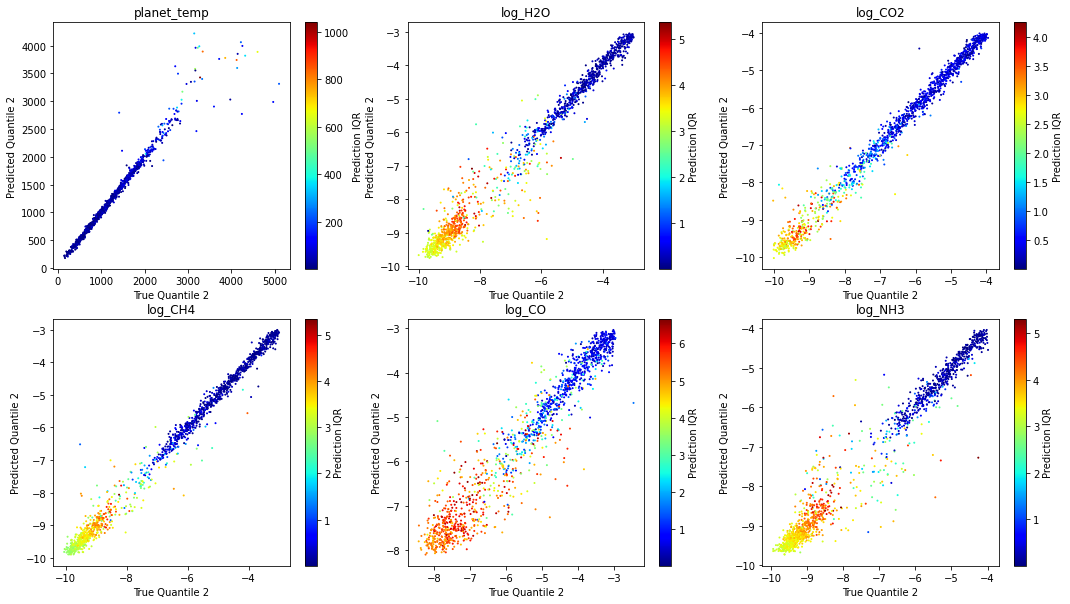

In [156]:
fig = plt.subplots(2,3,figsize=(18,10))

for i in range(len(targets_train.keys())):
    plt.subplot(231+i)
    plt.scatter(y_test_back_sreg_quart_all_new[:,i*3+1],y_pred_back_sreg_quart_all_new[:,i*3+1],c=np.abs(y_pred_back_sreg_quart_all_new[:,i*3+2]-y_pred_back_sreg_quart_all_new[:,i*3]),cmap='jet',s=1)
    plt.colorbar(label='Prediction IQR')
    plt.xlabel('True Quantile 2')
    plt.ylabel('Predicted Quantile 2')
    plt.title(targets_train.keys()[i])

plt.savefig('supervised_pred_vs_true.pdf')

Visualize on full 21988 instances (ran in a separate file, but can be easily reproduced from the above)

In [157]:
import matplotlib.gridspec as gridspec

In [158]:
supq = np.load('supervised_quart_from_stack_test.npy')
yq2         = quart_train[quart_train.keys()[:]][:21988]
yq2         = yq2.to_numpy()[:,:]

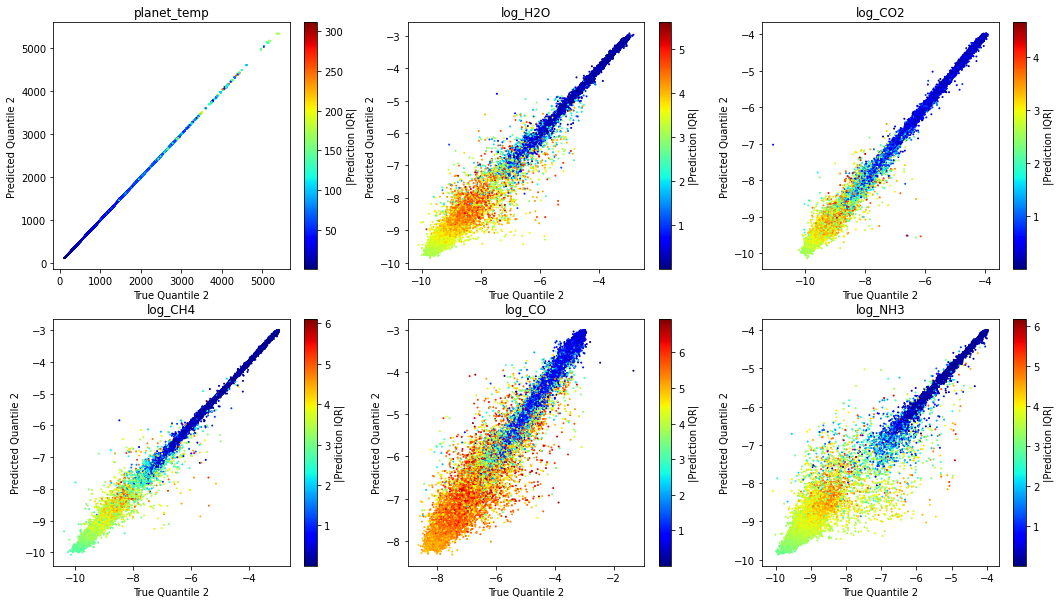

In [159]:
fig2 = plt.subplots(2,3,figsize=(18,10))

for i in range(len(targets_train.keys())):
    plt.subplot(231+i)
    plt.scatter(yq2[:,i*3+1],supq[:,i*3+1],c=np.abs(supq[:,i*3+2]-supq[:,i*3]),cmap='jet',s=1)
    plt.colorbar(label='|Prediction IQR|')
    plt.xlabel('True Quantile 2')
    plt.ylabel('Predicted Quantile 2')
    plt.title(targets_train.keys()[i])

plt.savefig('all_supervised_pred_vs_true.pdf')

# Ensemble Methods (Boosting - Ada, Gradient, XGB)

In [162]:
# run this if you need to install xgboost
#pip install xgboost

In [163]:
from sklearn.ensemble import GradientBoostingRegressor

In [164]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [165]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(x_train, y_train)
    y_pred_xg = xgb_reg.predict(x_test)
    val_error = mean_squared_error(y_test, y_pred_xg) # Not shown
    print("Validation MSE:", val_error)           # Not shown

Validation MSE: 0.06459963470367242


In [166]:
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(x_train, y_train,
                eval_set= [ (x_test, y_test) ], early_stopping_rounds=2)
    y_pred_xg2 = xgb_reg.predict(x_test)
    val_error2 = mean_squared_error(y_test, y_pred_xg2)  # Not shown
    print("Validation MSE:", val_error2)            # Not shown

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.85700
[1]	validation_0-rmse:0.67811
[2]	validation_0-rmse:0.56043
[3]	validation_0-rmse:0.48177
[4]	validation_0-rmse:0.42800
[5]	validation_0-rmse:0.39270
[6]	validation_0-rmse:0.36823
[7]	validation_0-rmse:0.35137
[8]	validation_0-rmse:0.33867
[9]	validation_0-rmse:0.33029
[10]	validation_0-rmse:0.32191
[11]	validation_0-rmse:0.31543
[12]	validation_0-rmse:0.31001
[13]	validation_0-rmse:0.30604
[14]	validation_0-rmse:0.30254
[15]	validation_0-rmse:0.30024
[16]	validation_0-rmse:0.29758
[17]	validation_0-rmse:0.29494
[18]	validation_0-rmse:0.29289
[19]	validation_0-rmse:0.29105
[20]	validation_0-rmse:0.28888
[21]	validation_0-rmse:0.28737
[22]	validation_0-rmse:0.28549
[23]	validation_0-rmse:0.28442
[24]	validation_0-rmse:0.28293
[25]	validation_0-rmse:0.28168
[26]	validation_0-rmse:0.28073
[27]	validation_0-rmse:0.27984
[28]	validation_0-rmse:0.27858
[29]	validation_0-rmse:0.27785
[30]	validation_0-rmse:0.27726
[31]	validation_0-rmse:0.27690
[32]	validation_0-

In [167]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42,early_stopping_rounds=15)
    xgb_reg.fit(X=x_train, y=y_train,eval_set=[(x_test, y_test)],verbose=False  )
    y_pred_xg_ariel = xgb_reg.predict(x_test)
    val_error = mean_squared_error(y_test, y_pred_xg_ariel)
    y_pred_xg_ariel_back = y_pred_xg_ariel*targets_train_stds + targets_train_means
    y_test_xg_back = y_test*targets_train_stds + targets_train_means
    score_xgb_ariel = score(y_test_xg_back,y_pred_xg_ariel_back)
    score_xgb_mae   = mae(y_test_xg_back,y_pred_xg_ariel_back)
    print('---Overall---')
    print('MAE: ',score_xgb_mae)
    print('Ariel Score: ',score_xgb_ariel)

---Overall---
MAE:  0.04067809381599531
Ariel Score:  993.9634697261118


# Standardization Column Wise

In [168]:
spec_train    = np.load('Data/TrainingData/spec_matrix.npy')
spec_train    = spec_train[:,:,1]

targets_train = pd.read_csv('Data/TrainingData/GroundTruth/FM_Parameter_Table.csv')
targets_train = targets_train.drop('planet_ID', axis=1)

In [169]:
# Training Data
spec_train_means    = np.mean(spec_train,axis=0)
spec_train_stds     = np.std(spec_train,axis=0)
spec_train          = (spec_train - spec_train_means)/spec_train_stds

targets_train_means = np.array([ np.mean(targets_train[targets_train.keys()[:]][:],axis=0) ])
targets_train_stds  = np.array([ np.std(targets_train[targets_train.keys()[:]][:],axis=0) ])
targets_train       = (targets_train - targets_train_means)/targets_train_stds

In [170]:
# limit out of 91k
N =  21988

x_train = spec_train[:N]

y_train = targets_train.to_numpy()[:N,:]

x_train, x_test, y_train, y_test = train_test_split(x_train, 
                                                    y_train, 
                                                    test_size=0.25,
                                                    random_state=0)

# Support Vector Machine (SVM) Regression

In [ ]:
scores_SVR = np.empty((6,1))
pred_SVR   = np.empty((y_test.shape[0],6))
for i in range(len(targets_train.keys()[:])):
    regr = SVR()
    regr.fit(x_train,y_train[:,i])
    pred_SVR = np.delete(pred_SVR,i,axis=1)
    pred_SVR = np.insert(pred_SVR,i,regr.predict(x_test),axis=1)
    scores_SVR[i] = regr.score(x_test,y_test[:,i])
    print('Accuracy for '+targets_train.keys()[i]+': ',np.round(scores_SVR[i],6))

Accuracy for planet_temp:  [0.113313]
Accuracy for log_H2O:  [0.078865]
Accuracy for log_CO2:  [-0.001825]
Accuracy for log_CH4:  [0.101851]
Accuracy for log_CO:  [-0.002252]


Ariel Scoring Metric

In [ ]:
y_pred_back = pred_SVR*targets_train_stds + targets_train_means
y_test_back = y_test*targets_train_stds + targets_train_means

In [ ]:
score_SVR_ariel = 100*(10-np.sqrt(np.sum((y_pred_back/y_test_back-1)**2)/(y_test_back.shape[0])/6))
print('Ariel Score: ',score_SVR_ariel)

# k-Nearest Neighbors

In [ ]:
k = 5
neigh = KNeighborsRegressor(n_neighbors=k)
neigh.fit(x_train,y_train)
pred_KNN = neigh.predict(x_test)
score_KNN = neigh.score(x_test,y_test)
print('Accuracy: ',score_KNN)

Ariel Scoring Metric

In [ ]:
y_pred_back = pred_KNN*targets_train_stds + targets_train_means

In [ ]:
score_KNN_ariel = 100*(10-np.sqrt(np.sum((y_pred_back/y_test_back-1)**2)/(y_test_back.shape[0])/6))
print('Ariel Score: ',score_KNN_ariel)